In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [2]:
from utils import load_twitter_graph_with_feature

G=load_twitter_graph_with_feature()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 23370, Edges: 32831

 Node types:
  default: [23370]
    Features: float32 vector, length 23370
    Edge types: default-default->default

 Edge types:
    default-default->default: [32831]
        Weights: all 1 (default)
        Features: none


In [4]:

edge_splitter_test = EdgeSplitter(G)


G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 3283 positive and 3283 negative edges. **


In [5]:

edge_splitter_train = EdgeSplitter(G_test)


G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 2954 positive and 2954 negative edges. **


In [6]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 23370, Edges: 26594

 Node types:
  default: [23370]
    Features: float32 vector, length 23370
    Edge types: default-default->default

 Edge types:
    default-default->default: [26594]
        Weights: all 1 (default)
        Features: none


In [7]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 23370, Edges: 29548

 Node types:
  default: [23370]
    Features: float32 vector, length 23370
    Edge types: default-default->default

 Edge types:
    default-default->default: [29548]
        Weights: all 1 (default)
        Features: none


In [8]:
batch_size = 20
epochs = 50

In [9]:
num_samples = [20, 10]

In [10]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [11]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [12]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [13]:

x_inp, x_out = graphsage.in_out_tensors()

In [14]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

c:\Users\Mohammadreza\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

329/329 [==============================] - 127s 386ms/step - loss: 0.7432 - binary_accuracy: 0.5577

Train Set Metrics of the initial (untrained) model:
	loss: 0.7675
	binary_accuracy: 0.5460

Test Set Metrics of the initial (untrained) model:
	loss: 0.7432
	binary_accuracy: 0.5577


In [17]:
history = model.fit_generator(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

C:\Users\Mohammadreza\AppData\Local\Temp\ipykernel_27744\3419235303.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)


Epoch 1/50
296/296 - 371s - loss: 0.5532 - binary_accuracy: 0.7527 - val_loss: 0.5361 - val_binary_accuracy: 0.7007 - 371s/epoch - 1s/step
Epoch 2/50
296/296 - 373s - loss: 0.3422 - binary_accuracy: 0.8932 - val_loss: 0.4344 - val_binary_accuracy: 0.8242 - 373s/epoch - 1s/step
Epoch 3/50
296/296 - 405s - loss: 0.2608 - binary_accuracy: 0.9247 - val_loss: 0.4471 - val_binary_accuracy: 0.8450 - 405s/epoch - 1s/step
Epoch 4/50
296/296 - 383s - loss: 0.2191 - binary_accuracy: 0.9362 - val_loss: 0.4360 - val_binary_accuracy: 0.8503 - 383s/epoch - 1s/step
Epoch 5/50
296/296 - 370s - loss: 0.1864 - binary_accuracy: 0.9509 - val_loss: 0.4460 - val_binary_accuracy: 0.8532 - 370s/epoch - 1s/step
Epoch 6/50
296/296 - 395s - loss: 0.1685 - binary_accuracy: 0.9597 - val_loss: 0.4276 - val_binary_accuracy: 0.8503 - 395s/epoch - 1s/step
Epoch 7/50
296/296 - 399s - loss: 0.1547 - binary_accuracy: 0.9599 - val_loss: 0.4348 - val_binary_accuracy: 0.8547 - 399s/epoch - 1s/step
Epoch 8/50
296/296 - 398s -

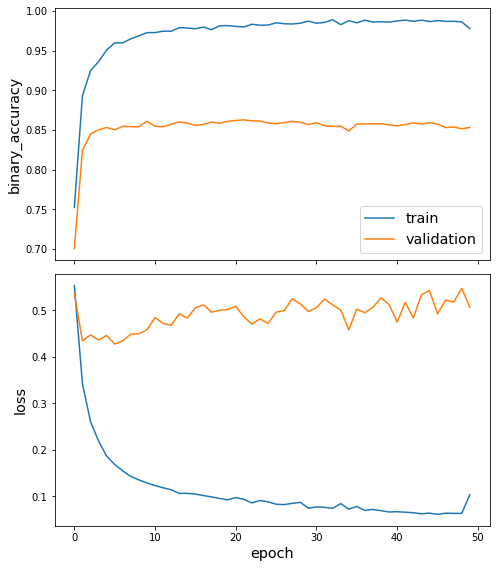

In [18]:
sg.utils.plot_history(history)

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

329/329 [==============================] - 130s 394ms/step - loss: 0.5161 - binary_accuracy: 0.8532

Train Set Metrics of the trained model:
	loss: 0.0482
	binary_accuracy: 0.9959

Test Set Metrics of the trained model:
	loss: 0.5161
	binary_accuracy: 0.8532
